In [1]:
import polars as pl
import torch
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns
from amaretto_mlp import *
from utils_b import *
from autoencoder import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
#df = load_data(r'amaretto_transformed_scaled.pq')

## Experiment #1 : Autoencoder only

In [2]:
df = pl.read_parquet("amaretto_transformed_scaled.pq")
df

id,datetime,Originator,Anomaly,Anomaly_bin,amount_log,InputOutput_Buy,InputOutput_Sell,Market_1,Market_2,Market_3,Market_4,Product Type_ADR,Product Type_Bond,Product Type_CAADR,Product Type_ETOEquity,Product Type_ETOEquityIndex,Product Type_Equity,Product Type_FX,Product Type_FXForward,Product Type_FXSwap,Product Type_FutureBond,Product Type_FutureCommodity,Product Type_FutureEquity,Product Type_FutureEquityIndex,Product Type_FutureFX,Product Type_FutureOptionEquityIndex,Product Type_Repo,Product Type_SimpleTransfer,Product Class_ADR Conversion,"Product Class_Cash in / out (withdrawal), Security in / out",Product Class_External fee,Product Class_Trade,Currency_1,Currency_2,day_of_week,day_of_month,…,rolling_n_transactions_12h,rolling_n_transactions_24h,rolling_n_transactions_7d,rolling_mean_originator_1h,rolling_mean_originator_12h,rolling_mean_originator_24h,rolling_mean_originator_7d,rolling_std_originator_1h,rolling_std_originator_12h,rolling_std_originator_24h,rolling_std_originator_7d,rolling_max_originator_1h,rolling_max_originator_12h,rolling_max_originator_24h,rolling_max_originator_7d,rolling_min_originator_1h,rolling_min_originator_12h,rolling_min_originator_24h,rolling_min_originator_7d,rolling_sum_originator_1h,rolling_sum_originator_12h,rolling_sum_originator_24h,rolling_sum_originator_7d,rolling_n_transactions_originator_1h,rolling_n_transactions_originator_12h,rolling_n_transactions_originator_24h,rolling_n_transactions_originator_7d,cumcount_InputOutput,cumcount_Market,cumcount_Product Type,cumcount_Product Class,cumcount_Currency,InputOutput_freq_originator,Market_freq_originator,Product Type_freq_originator,Product Class_freq_originator,Currency_freq_originator
u32,datetime[μs],str,i64,i8,f64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,i8,i8,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
151925,2019-01-01 00:00:03,"""Client_259""",0,0,0.392679,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2,1,…,-15.681047,-19.407062,-34.615714,-12.375985,-33.285581,-42.036975,-122.008372,-9.297571,-28.438271,-34.888399,-116.054396,-9.914659,-28.656326,-35.353446,-93.635163,-12.234035,-30.772611,-31.90101,-55.86845,-9.099869,-12.938788,-14.257223,-17.684867,-3.488935,-4.521771,-5.222825,-7.016616,-6.18689,-5.461002,-4.45734,-5.261721,-6.025219,19.130933,3.273489,10.168608,1.312785,1.759253
196838,2019-01-01 00:00:07,"""Client_133""",0,0,0.541257,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2,1,…,-14.73846,-18.305018,-32.894988,-12.375985,-33.285581,-42.036975,-122.008372,-9.297571,-28.438271,-34.888399,-116.054396,-9.914659,-28.656326,-35.353446,-93.635163,-12.234035,-30.772611,-31.90101,-55.86845,-9.099869,-12.938788,-14.257223,-17.684867,-3.488935,-4.521771,-5.222825,-7.016616,-6.18689,-5.461002,-4.45734,-5.261721,-6.025219,19.130933,3.273489,10.168608,1.312785,1.759253
463308,2019-01-01 00:00:07,"""Client_042""",0,0,-1.658164,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,2,1,…,-14.73846,-18.305018,-32.894988,-12.375985,-33.285581,-42.036975,-122.008372,-9.297571,-28.438271,-34.888399,-116.054396,-9.914659,-28.656326,-35.353446,-93.635163,-12.234035,-30.772611,-31.90101,-55.86845,-9.099869,-12.938788,-14.257223,-17.684867,-3.488935,-4.521771,-5.222825,-7.016616,-6.18689,-5.461002,-4.45734,-5.261721,-6.025219,19.130933,3.273489,10.168608,1.312785,1.759253
570827,2019-01-01 00:00:08,"""Client_019""",0,0,0.646217,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,2,1,…,-14.435015,-17.95024,-32.341037,-12.375985,-33.285581,-42.036975,-122.008372,-9.297571,-28.438271,-34.888399,-116.054396,-9.914659,-28.656326,-35.353446,-93.635163,-12.234035,-30.772611,-31.90101,-55.86845,-9.099869,-12.938788,-14.257223,-17.684867,-3.488935,-4.521771,-5.222825,-7.016616,-6.18689,-5.461002,-4.45734,-5.261721,-6.025219,19.130933,3.273489,10.168608,1.312785,1.75

In [3]:
df_train, df_val, df_test = split_data(df)
columns_to_drop = ['id', 'Anomaly', 'Anomaly_bin', 'Originator', 'datetime']

target_column = 'Anomaly'
y_train = df_train.select(target_column).to_numpy().flatten()
df_train = df_train.drop(columns_to_drop)
X_train = df_train.to_numpy()
y_val = df_val.select(target_column).to_numpy().flatten()
X_val = df_val.drop(columns_to_drop).to_numpy()
y_test = df_test.select(target_column).to_numpy().flatten()
X_test = df_test.drop(columns_to_drop).to_numpy()
print(X_train.shape)

train_dataset = AmarettoDataset(X_train, y_train)
val_dataset = AmarettoDataset(X_val, y_val)
test_dataset = AmarettoDataset(X_test, y_test)

(24451934, 125)


In [4]:
train_loader = DataLoader(train_dataset, batch_size=256, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=256, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=256, num_workers=2)
input_dim = X_train.shape[1]
print(len(train_loader))  # Should print an integer`

95516


In [5]:
model = Autoencoder(input_dim=X_train.shape[1], hidden_layers=[64], latent_dim=16)
model.load_state_dict(torch.load("autoencoder_16.pth"))

<All keys matched successfully>

In [5]:
model = train(train_loader, val_loader, input_dim, hidden_layers=[64], latent_dim=16, epochs=3, lr=0.0001)

Epoch 1/3 [Training]:   0%|          | 0/95516 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6590, Val Loss = 0.8061


Epoch 2/3 [Training]:   0%|          | 0/95516 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.2346, Val Loss = 0.7886


Epoch 3/3 [Training]:   0%|          | 0/95516 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.2133, Val Loss = 0.8531


In [6]:
torch.save(model.state_dict(), "autoencoder_16.pth")

In [6]:
model2 = train(train_loader, val_loader, input_dim, hidden_layers=[32, 16], latent_dim=2, epochs=3, lr=0.0001)

Epoch 1/3 [Training]:   0%|          | 0/95516 [00:00<?, ?it/s]

Epoch 1: Train Loss = 1.5009, Val Loss = 1.3186


Epoch 2/3 [Training]:   0%|          | 0/95516 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.7172, Val Loss = 1.4081


Epoch 3/3 [Training]:   0%|          | 0/95516 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.6513, Val Loss = 1.5737


In [7]:
torch.save(model2.state_dict(), "autoencoder_2.pth")


In [39]:
X, y = sample_data(X_test, y_test, n_samples=10000, anomaly_ratio=0.1)
y_bin = (y != 0) * 1

[ 66  38 212 542 530]


In [8]:
X = X_test[y_test != 0]
y = y_test[y_test != 0]
X.shape

(6681, 125)

In [80]:
y_bin = (y != 0) * 1
y_bin.shape

(1388,)

In [9]:
model.eval()
X_tensor = torch.tensor(X, dtype=torch.float32)
with torch.no_grad():
    z_test = model.encode(X_tensor)

In [10]:
z_test = z_test.cpu().numpy()


In [11]:
z_test.shape

(6681, 16)

In [12]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(z_test)
embedding.shape

/home/darosali/BP/amaretto/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(6681, 2)

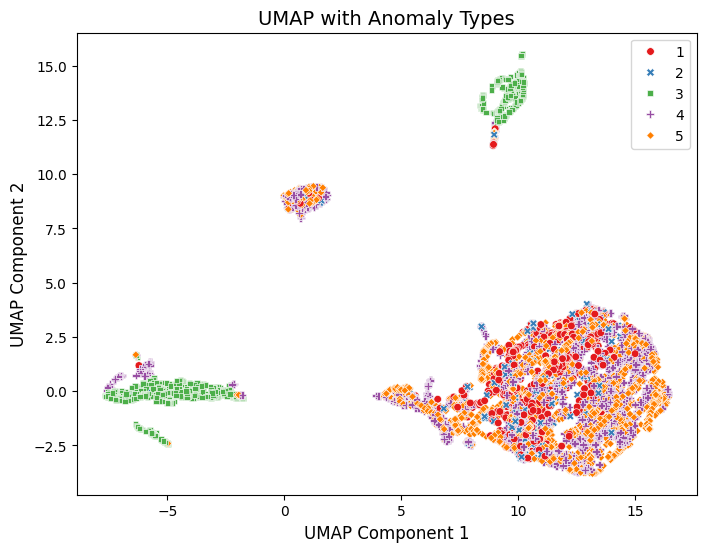

In [13]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=y, palette="Set1", s=30, style=y, legend="full")
plt.title('UMAP with Anomaly Types', fontsize=14)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
#plt.legend(title="Labels", labels=["Normal", "Fraud"])
plt.show()

In [14]:
X_embedded = TSNE(n_components=2).fit_transform(z_test)
X_embedded.shape

(6681, 2)

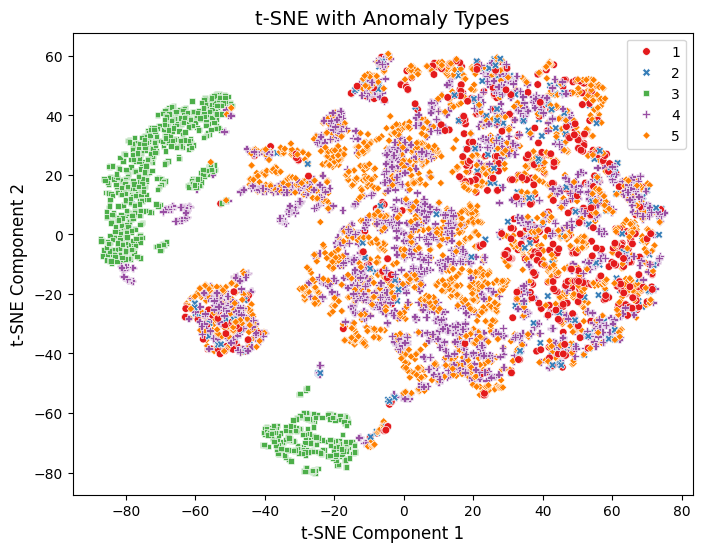

In [15]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y, palette="Set1", s=30, style=y, legend="full")
plt.title('t-SNE with Anomaly Types', fontsize=14)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
#plt.legend(title="Labels", labels=["Normal", "Fraud"])
plt.show()

In [16]:
X = X_test[y_test != 0]
y = y_test[y_test != 0]
print(X.shape)
model2.eval()
X_tensor = torch.tensor(X, dtype=torch.float32)
with torch.no_grad():
    z_test = model2.encode(X_tensor)
z_test = z_test.cpu().numpy()
z_test.shape

(6681, 125)


(6681, 2)

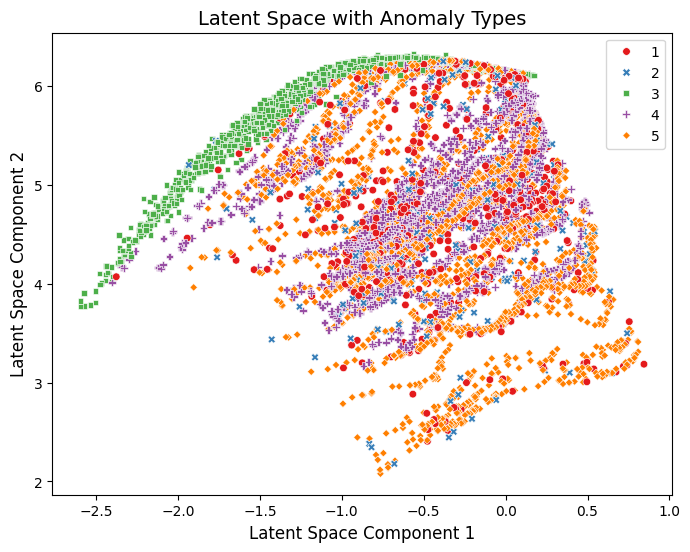

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=z_test[:, 0], y=z_test[:, 1], hue=y, palette="Set1", s=30, style=y, legend="full")
plt.title('Latent Space with Anomaly Types', fontsize=14)
plt.xlabel('Latent Space Component 1', fontsize=12)
plt.ylabel('Latent Space Component 2', fontsize=12)
#plt.legend(title="Labels", labels=["Normal", "Fraud"])
plt.show()

## Experiment #2: Autoencoder -> Latent Space -> Classification

In [6]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights

tensor([1.6713e-01, 8.4253e+02, 1.9612e+03, 4.1764e+02, 1.5445e+02, 1.6420e+02])

In [7]:
z_train_list = []
model.eval()
with torch.no_grad():
    for x_batch, _ in train_loader:
        z_batch = model.encode(x_batch).cpu().numpy()
        z_train_list.append(z_batch)

# Concatenate all batches
z_train = np.concatenate(z_train_list, axis=0)
# with torch.no_grad():
#     for x, _ in train_loader:
#         z = model.encode(x)  # Extract latent features
#         z_train_list.append(z)
        
# z_train = torch.cat(z_train_list, dim=0)
print(z_train.shape)

X_tensor = torch.tensor(X_val, dtype=torch.float32)
with torch.no_grad():
    z_val = model.encode(X_tensor)

(24451934, 16)


torch.Size([2486401, 16])

In [9]:
z_val.shape

(2486401, 16)

In [9]:
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

In [13]:
mlp_classifier = train_classifier(z_train, y_train_tensor, z_val, y_val_tensor, latent_dim=z_train.shape[1], num_classes=6, epochs=3, lr=0.0001, class_weights=class_weights)

Epoch 1/3 [Training Classifier]:   0%|          | 0/95516 [00:00<?, ?it/s]

Epoch 1: Train Class Loss = 0.8134, Val Class Loss = 0.6382


Epoch 2/3 [Training Classifier]:   0%|          | 0/95516 [00:00<?, ?it/s]

Epoch 2: Train Class Loss = 0.6426, Val Class Loss = 0.5639


Epoch 3/3 [Training Classifier]:   0%|          | 0/95516 [00:00<?, ?it/s]

Epoch 3: Train Class Loss = 0.5881, Val Class Loss = 0.5529


In [18]:
torch.save(mlp_classifier.state_dict(), "classifier_16.pth")

In [6]:
def predict_labels(classifier, encoder, x):
    with torch.no_grad():
        z = encoder(x)  # Encode input into latent space
        logits = classifier(z)  # Get raw outputs (logits)
        predictions = torch.argmax(logits, dim=1)  # Get predicted class labels
    return z, predictions

In [7]:
mlp_classifier = Classifier(latent_dim=16, num_classes=6)
mlp_classifier.load_state_dict(torch.load("classifier_16.pth"))

<All keys matched successfully>

In [8]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [9]:
z_test, y_pred = predict_labels(mlp_classifier, model.encoder, X_test_tensor)
y_pred = y_pred.cpu().detach().numpy()
print(y_pred.shape)
print(z_test.shape)

(2765755,)
torch.Size([2765755, 16])


In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99   2759074
           1       0.02      0.04      0.03       576
           2       0.00      0.00      0.00       257
           3       0.07      0.99      0.13      1175
           4       0.07      0.73      0.13      2228
           5       0.03      0.29      0.05      2445

    accuracy                           0.98   2765755
   macro avg       0.20      0.51      0.22   2765755
weighted avg       1.00      0.98      0.99   2765755



/home/darosali/BP/amaretto/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darosali/BP/amaretto/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darosali/BP/amaretto/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [ ]:
xgb_classifier = train_xgboost_classifier(z_train, y_train, z_val, y_val)

/home/darosali/BP/amaretto/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:38:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [197]:
preds = xgb_classifier.predict(z_test)

In [ ]:
z_train_list = []
model.eval()
# with torch.no_grad():
#     for x_batch, _ in train_loader:
#         z_batch = model.encode(x_batch).cpu().numpy()
#         z_train_list.append(z_batch)

# z_train = np.concatenate(z_train_list, axis=0)
with torch.no_grad():
    for x, _ in train_loader:
        z = model2.encode(x)  # Extract latent features
        z_train_list.append(z)
        
z_train = torch.cat(z_train_list, dim=0)
print(z_train.shape)

X_tensor = torch.tensor(X_val, dtype=torch.float32)
with torch.no_grad():
    z_val = model2.encode(X_tensor)

In [ ]:
mlp_classifier = train_classifier(z_train, y_train_tensor, z_val, y_val_tensor, latent_dim=z_train.shape[1], num_classes=6, epochs=3, lr=0.0001, class_weights=class_weights)

In [ ]:
X = z_test[preds != 0]
y = preds[preds != 0]
print(X.shape)
print(y.shape)
reducer = umap.UMAP()
embedding = reducer.fit_transform(X)
embedding.shape

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y, palette="Set1", s=30, style=y, legend="full")
plt.title('t-SNE with Anomaly Types', fontsize=14)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
#plt.legend(title="Labels", labels=["Normal", "Fraud"])
plt.show()

## Experiment #3: End-to-end model

In [7]:
model_combined = train_combined(train_loader, val_loader, input_dim, hidden_layers=[64, 32], latent_dim=16, num_classes=6, epochs=3, lr=0.0001, alpha=0.5, class_weights=class_weights)

Epoch 1/3 [Training]:   0%|          | 0/191031 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4091, Val Loss = 0.7133


Epoch 2/3 [Training]:   0%|          | 0/191031 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.1733, Val Loss = 0.7638


Epoch 3/3 [Training]:   0%|          | 0/191031 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.1492, Val Loss = 1.2196


In [8]:
model_combined.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    _, y_pred, z_test = model_combined(X_test_tensor)
    y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.cpu().detach().numpy()
print(y_pred.shape)
z_test = z_test.cpu().numpy()
print(z_test.shape)

(2765755,)
(2765755, 16)


In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2759074
           1       0.18      0.64      0.29       576
           2       0.82      0.55      0.66       257
           3       0.65      0.71      0.68      1175
           4       0.32      0.91      0.47      2228
           5       0.47      0.40      0.43      2445

    accuracy                           1.00   2765755
   macro avg       0.57      0.70      0.59   2765755
weighted avg       1.00      1.00      1.00   2765755



In [10]:
y_pred_a = y_pred[y_pred != 0]
z_test_a = z_test[y_pred != 0]
z_test_a.shape

(11880, 16)

In [15]:
y_test_a = y_test[y_pred != 0]
y_test_a.shape

(11880,)

In [11]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(z_test_a)
embedding.shape

/home/darosali/BP/amaretto/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(11880, 2)

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=y_pred_a, palette="Set1", s=30, style=y_pred_a, legend="full")
plt.title('UMAP with Anomaly Types', fontsize=14)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
#plt.legend(title="Labels", labels=["Normal", "Fraud"])
plt.show()

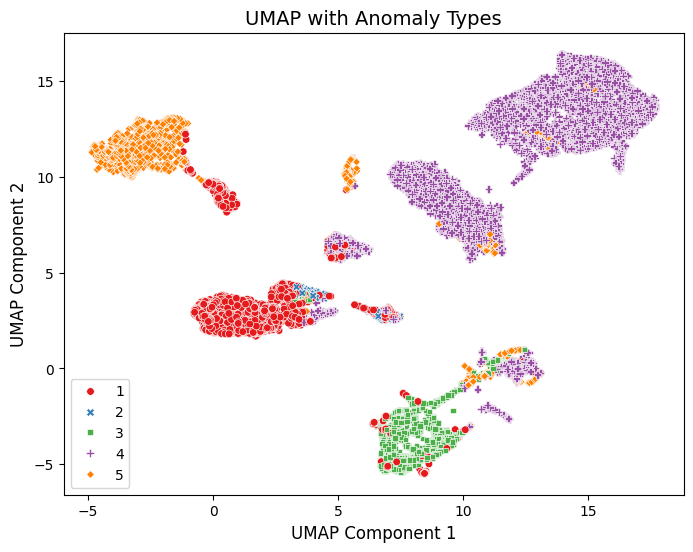

In [12]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=y_pred_a, palette="Set1", s=30, style=y_pred_a, legend="full")
plt.title('UMAP with Anomaly Types', fontsize=14)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
#plt.legend(title="Labels", labels=["Normal", "Fraud"])
plt.show()

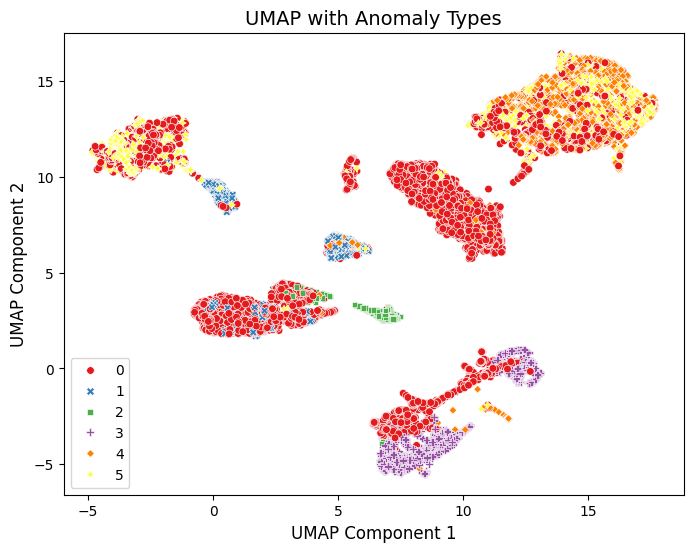

In [16]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=y_test_a, palette="Set1", s=30, style=y_test_a, legend="full")
plt.title('UMAP with Anomaly Types', fontsize=14)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
#plt.legend(title="Labels", labels=["Normal", "Fraud"])
plt.show()

In [17]:
X_embedded = TSNE(n_components=2).fit_transform(z_test_a)
X_embedded.shape

(11880, 2)

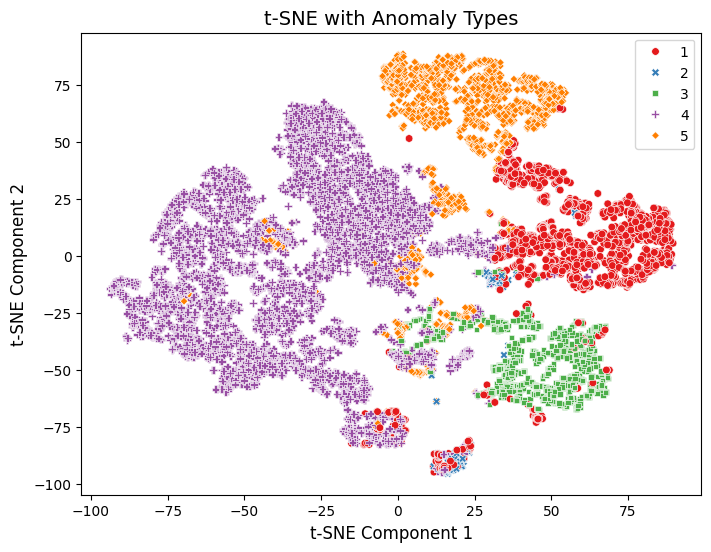

In [19]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_pred_a, palette="Set1", s=30, style=y_pred_a, legend="full")
plt.title('t-SNE with Anomaly Types', fontsize=14)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
#plt.legend(title="Labels", labels=["Normal", "Fraud"])
plt.show()

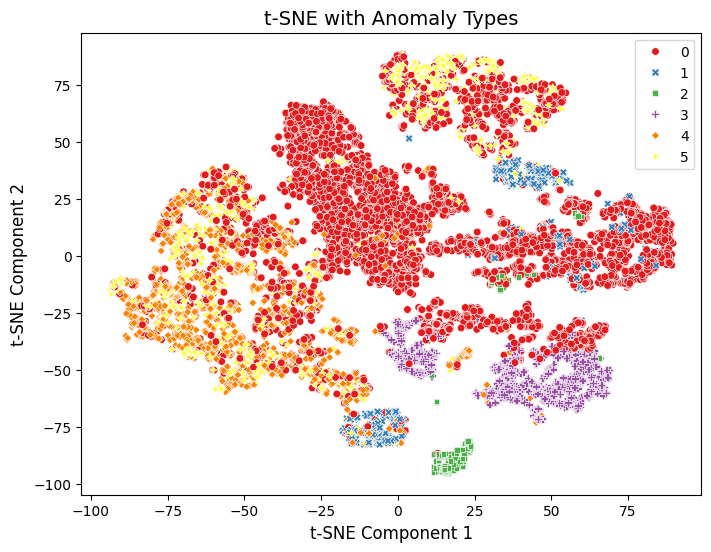

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_test_a, palette="Set1", s=30, style=y_test_a, legend="full")
plt.title('t-SNE with Anomaly Types', fontsize=14)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
#plt.legend(title="Labels", labels=["Normal", "Fraud"])
plt.show()